<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-3)" data-toc-modified-id="Общее-впечатление-(ревью-3)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 3)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SGDClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Установка доп. модулей

In [9]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install stop-words

In [23]:
pip install textblob

     |████████████████████████████████| 636 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Импорт необходимых библиотек

In [61]:
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import pandas as pd

import re

from pymystem3 import Mystem

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, recall_score
from sklearn.utils import shuffle

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

from lightgbm import LGBMRegressor

from textblob import TextBlob, Word


Загрузка данных и вывод на экран.

In [25]:
try:  
    data = pd.read_csv('C:/projects/toxic_comments.csv')
except OSError as e:
    data = pd.read_csv('/datasets/toxic_comments.csv')
display(data.head())
display(data.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

In [6]:
print("Кол-во строк =",data.shape[0])
print("Кол-во столбцов =",data.shape[1])
print('Кол-во дубликатов:', data.duplicated().sum())
print('Кол-во значений N/A:', data.isna().sum())

Кол-во строк = 159571
Кол-во столбцов = 2
Кол-во дубликатов: 0
Кол-во значений N/A: text     0
toxic    0
dtype: int64


Составим облако слов Токсичных комментариев и Не Токсичных.

(-0.5, 399.5, 199.5, -0.5)

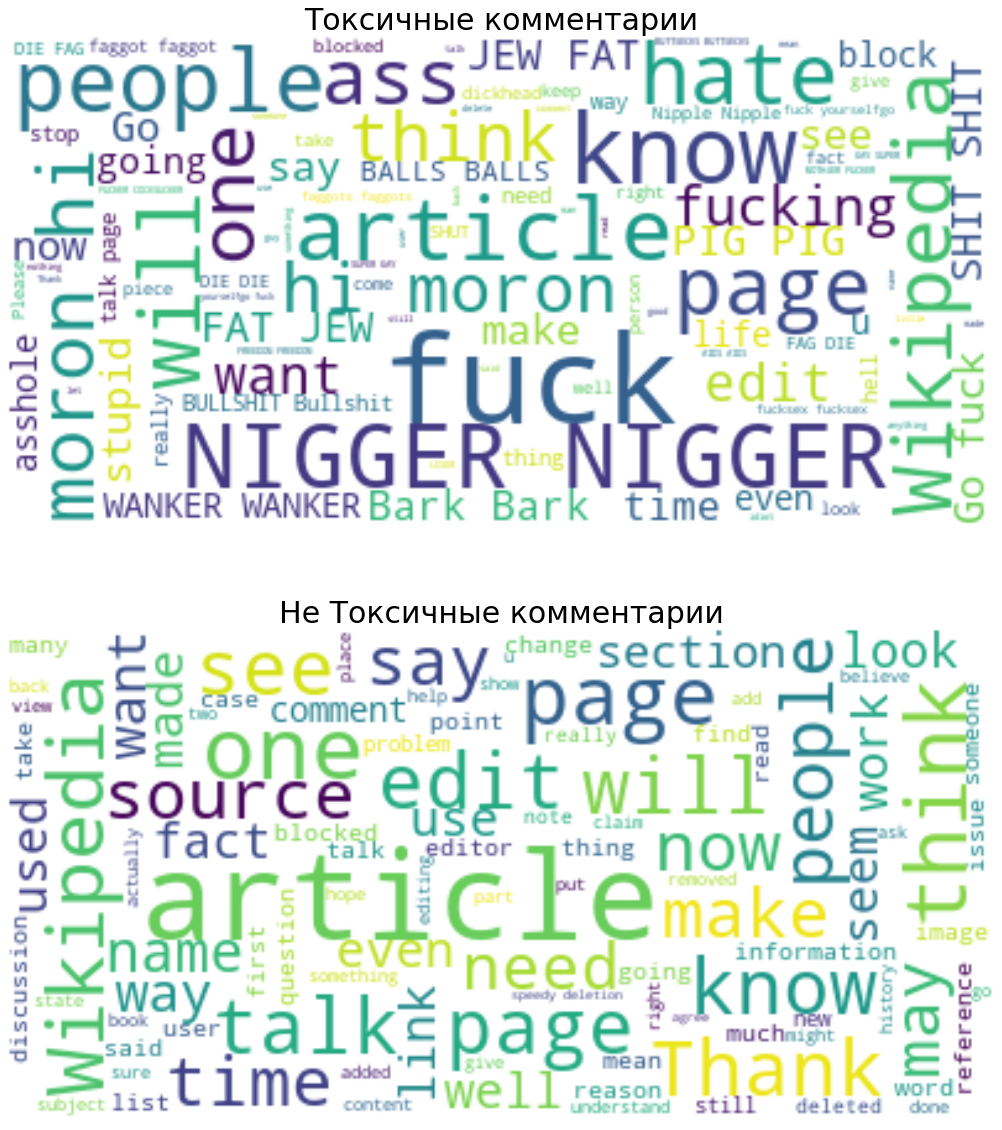

In [7]:
data_toxic = data[data['toxic']==1]
data_nottoxic = data[data['toxic']==0]


toxic = " ".join(review for review in data_toxic.text)
nottoxic = " ".join(review for review in data_nottoxic.text)

fig, ax = plt.subplots(2, 1, figsize  = (20,20))
wordcloud_toxic = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(toxic)
wordcloud_nottoxic = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(nottoxic)



ax[0].imshow(wordcloud_toxic, interpolation='bilinear')
ax[0].set_title('Токсичные комментарии',fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_nottoxic, interpolation='bilinear')
ax[1].set_title('Не Токсичные комментарии',fontsize=30)
ax[1].axis('off')

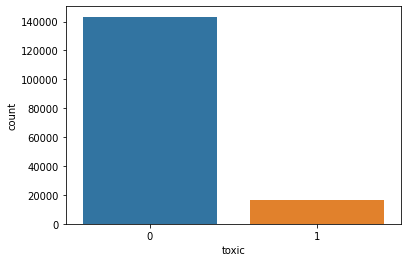

In [8]:
sns.countplot(x = 'toxic', data = data);

По графику видно, что классы несбалансированы, поэтому проивзедем расчет f1 Меры с балансом классов и без и сравним результат.

Для обучения подготовим целовой признак и признаки.

In [27]:
%%time

def blob(data):
    sentence = data
    sent = TextBlob(sentence)
    return " ". join([w.lemmatize() for w in sent.words])

data['lemmatize_text'] = data['text'].apply(lambda x: blob(x))

data = data.drop(['text'], axis=1)

CPU times: user 2min 36s, sys: 272 ms, total: 2min 36s
Wall time: 2min 36s


In [ ]:
#%%time

#wn = nltk.WordNetLemmatizer()

#def text_lemmatize(text):
    text = text.lower()
    lemmatize_text = "".join(wn.lemmatize(word))
    clear_text = re.sub(r'[^a-zA-Z]', ' ', lemmatize_text) 
    return " ".join(clear_text.split())

#data['lemmatize_text'] = data['text'].apply(text_lemmatize)

#data = data.drop(['text'], axis=1)
#
#del wn

In [28]:
data.head()

,toxic,lemmatize_text
0,0,Explanation Why the edits made under my userna...
1,0,D'aww He match this background colour I 'm see...
2,0,Hey man I 'm really not trying to edit war It ...
3,0,More I ca n't make any real suggestion on impr...
4,0,You sir are my hero Any chance you remember wh...


Разобьем выборку на обучающую, тестовую и валидационную. Кол-во cv сократим до 3х. 

In [41]:
target = data['toxic']
features = data.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12345)

In [42]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords) # вызов TFIDF

features_train = count_tf_idf.fit_transform(features_train['lemmatize_text'])
features_valid = count_tf_idf.transform(features_valid['lemmatize_text'])
features_test = count_tf_idf.transform(features_test['lemmatize_text'])
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_count = 3

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(95742, 135522)
(31914, 135522)
(31915, 135522)


Рассчитаем F1-меру

In [44]:
%%time

model = LogisticRegression()

f1_train = cross_val_score(model, 
                      features_train, 
                      target_train, 
                      cv=cv_count, 
                      scoring='f1').mean()
print('F1-мера', f1_train)

F1-мера 0.6711888889617027
CPU times: user 26.9 s, sys: 1min 8s, total: 1min 35s
Wall time: 1min 35s


**Изменим баланс классов**

In [92]:
%%time

model = LogisticRegression(class_weight='balanced')
f1_train_balance = cross_val_score(model, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_count, 
                                    scoring='f1').mean()
print('F1-мера с балансированными классами', f1_train_balance)

F1-мера с балансированными классами 0.7444308965221991
CPU times: user 17.9 s, sys: 40.5 s, total: 58.4 s
Wall time: 58.6 s


F1-мера увеличилась благодаря балансу классов.

Произведем расчет F1 на валидационной выборке

In [100]:
model = LogisticRegression()
model.fit(features_train, target_train)
f1_valid = f1_score(target_valid, model.predict(features_valid))


model = LogisticRegression(class_weight='balanced')
model.fit(features_train, target_train)
f1_valid_balance = f1_score(target_valid, model.predict(features_valid))

print('F1-мера :', f1_valid)
print('F1-мера баланс класса:', f1_valid_balance)

F1-мера : 0.7272385252069224
F1-мера баланс класса: 0.7539497183679077


Сравним результат.

In [101]:
index = ['LR',
         'LR баланс класса']
data = {'F1-мера на CV':[f1_train,
                    f1_train_balance],
       'F1-мера на валидации':[f1_valid,
                           f1_valid_balance]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1-мера на CV,F1-мера на валидации
LR,0.673275,0.727239
LR баланс класса,0.744431,0.753950


**Вывод**
<br>

Данные подготолвены для обучения. Выборка разделена на обучаущую, тестовую и валидационну.
<br>
Выберем метод с балансом класса и примением его в обучении.

## Обучение

Для обучения выберем следующие модели:

- LogisticRegression
- CatBoostClassifier
- SGDClassifier

### LogisticRegression

In [103]:
%%time

model = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':['balanced']}]

clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_count)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

Лучшие параметры:

{'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}
CPU times: user 2min 29s, sys: 4min 42s, total: 7min 11s
Wall time: 7min 11s


In [107]:
%%time

f1_LR_cv = max(means)

model = LogisticRegression()
model.set_params(**LR_best_params)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
f1_LR_valid = f1_score(target_valid, target_predict)
print('F1-мера на cv', f1_LR_cv)
print('F1-мера на валидации', f1_LR_valid)

F1-мера на cv 0.7644370518030073
F1-мера на валидации 0.7676354607857456
CPU times: user 11.9 s, sys: 25.6 s, total: 37.5 s
Wall time: 37.5 s


### CatBoostClassifier

In [114]:
%%time

model = CatBoostClassifier(verbose=False, iterations=200)
model.fit(features_train, target_train)
f1_CBC_cv = cross_val_score(model,
                         features_train, 
                         target_train, 
                         cv=cv_count, 
                         scoring='f1').mean()
print('F1-мера на cv', f1_CBC_cv)

F1-мера на cv 0.727876009952182
CPU times: user 20min 8s, sys: 5min 2s, total: 25min 11s
Wall time: 25min 18s


In [115]:
target_predict = model.predict(features_valid)
f1_CBC_valid = f1_score(target_valid, target_predict)
print('F1-мера на валидации', f1_CBC_valid)

F1-мера на валидации 0.749050117604487


### SGDClassifier

In [111]:
%%time

model = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[12345],
                'class_weight':['balanced']}]


clf = GridSearchCV(model, hyperparams, scoring='f1',cv=cv_count)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

Лучшие параметры:

{'class_weight': 'balanced', 'eta0': 0.2, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12345}
CPU times: user 2min 28s, sys: 25.7 s, total: 2min 54s
Wall time: 2min 54s


In [113]:
%%time

f1_SGDC_cv = max(means)
model = SGDClassifier()
model.set_params(**SGDC_best_params)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
f1_SGDC_valid = f1_score(target_valid, target_predict)
print('F1-мера на cv', f1_SGDC_cv)
print('F1-мера на валидации', f1_SGDC_valid)

F1 на cv 0.7533872706082957
F1 на валидации 0.7624187076241872
CPU times: user 1.43 s, sys: 230 ms, total: 1.66 s
Wall time: 1.6 s


**Выведем таблицу моделей**

In [117]:
index = ['LogisticRegression',
         'CatBoostClassifier',
         'SGDClassifier']
data = {'F1 на CV':[f1_LR_cv,
                    f1_CBC_cv,
                    f1_SGDC_cv],
        'F1 на валидации':[f1_LR_valid,
                           f1_CBC_valid,
                           f1_SGDC_valid]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['F1 > 0.75'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,F1 > 0.75
LogisticRegression,0.764437,0.767635,True
CatBoostClassifier,0.727876,0.749050,False
SGDClassifier,0.753387,0.762419,True


**Вывод**
<br>

Исходя из полученной таблицы для тестовой выборки подойдут модели LogisticRegressioN и SGDClassifier.

## Выводы

Произведем расчет F1 - меры на выбранных ранее моделях.

In [120]:
model = LogisticRegression()
model.set_params(**LR_best_params)
model.fit(features_train, target_train)
predict_test = model.predict(features_test)
print('F1 LR:', f1_score(target_test, predict_test))

print()

model = SGDClassifier()
model.set_params(**SGDC_best_params)
model.fit(features_train, target_train)
predict_test = model.predict(features_test)

print('F1 SGDC:', f1_score(target_test, predict_test))



F1 LR: 0.7697300486797463

F1 SGDC: 0.7545644599303136


**Вывод**
<br>
В ходе исследования было сделано следующее:
- Имеющиеся данные было подгтовлены дял обучения.
- ДАнные были поделены на обучающую, валидационную и тестовою выборки.
- Лучшими поделями показали себя LogisticRegression и SGDClassifier.
<br>

По итогу лучше в сравении по метрике F1 лучше всего себя показала модель LogisticRegression.